In [68]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.raw_engine

In [69]:
df = pd.read_sql("SELECT * FROM BTCUSD_15m",engine)
df.set_index('Datetime',inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-02-03 03:00:00,36997.386719,36997.386719,36954.027344,36955.273438,36955.273438,0
2022-02-03 03:15:00,36966.984375,36988.691406,36920.898438,36922.066406,36922.066406,165888
2022-02-03 03:30:00,36918.144531,36935.207031,36899.984375,36931.457031,36931.457031,29073408
2022-02-03 03:45:00,36931.261719,36931.261719,36862.578125,36870.757812,36870.757812,25690112
2022-02-03 04:00:00,36868.261719,36948.675781,36861.207031,36945.785156,36945.785156,35790848
...,...,...,...,...,...,...
2022-03-03 02:15:00,43739.042969,43797.878906,43739.042969,43795.156250,43795.156250,10727424
2022-03-03 02:30:00,43791.382812,43791.382812,43687.863281,43791.257812,43791.257812,145903616
2022-03-03 02:45:00,43783.078125,43806.292969,43760.609375,43806.292969,43806.292969,12699648


<AxesSubplot:>

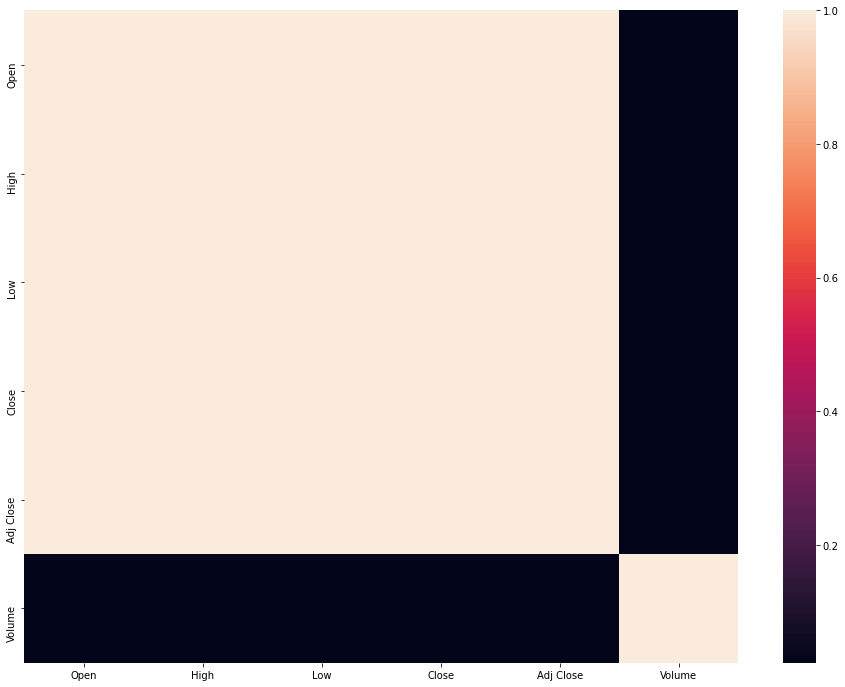

In [70]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr())

o,h,l,c는 실상 동일하므로 피쳐를 조합해 새로운 피쳐를 만들어준다.

In [71]:
gap = (df['High'] - df['Low'])
df['Gap'] = gap
df

,Open,High,Low,Close,Adj Close,Volume,Gap
Datetime,,,,,,,
2022-02-03 03:00:00,36997.386719,36997.386719,36954.027344,36955.273438,36955.273438,0,43.359375
2022-02-03 03:15:00,36966.984375,36988.691406,36920.898438,36922.066406,36922.066406,165888,67.792969
2022-02-03 03:30:00,36918.144531,36935.207031,36899.984375,36931.457031,36931.457031,29073408,35.222656
2022-02-03 03:45:00,36931.261719,36931.261719,36862.578125,36870.757812,36870.757812,25690112,68.683594
2022-02-03 04:00:00,36868.261719,36948.675781,36861.207031,36945.785156,36945.785156,35790848,87.468750
...,...,...,...,...,...,...,...
2022-03-03 02:15:00,43739.042969,43797.878906,43739.042969,43795.156250,43795.156250,10727424,58.835938
2022-03-03 02:30:00,43791.382812,43791.382812,43687.863281,43791.257812,43791.257812,145903616,103.519531
2022-03-03 02:45:00,43783.078125,43806.292969,43760.609375,43806.292969,43806.292969,12699648,45.683594


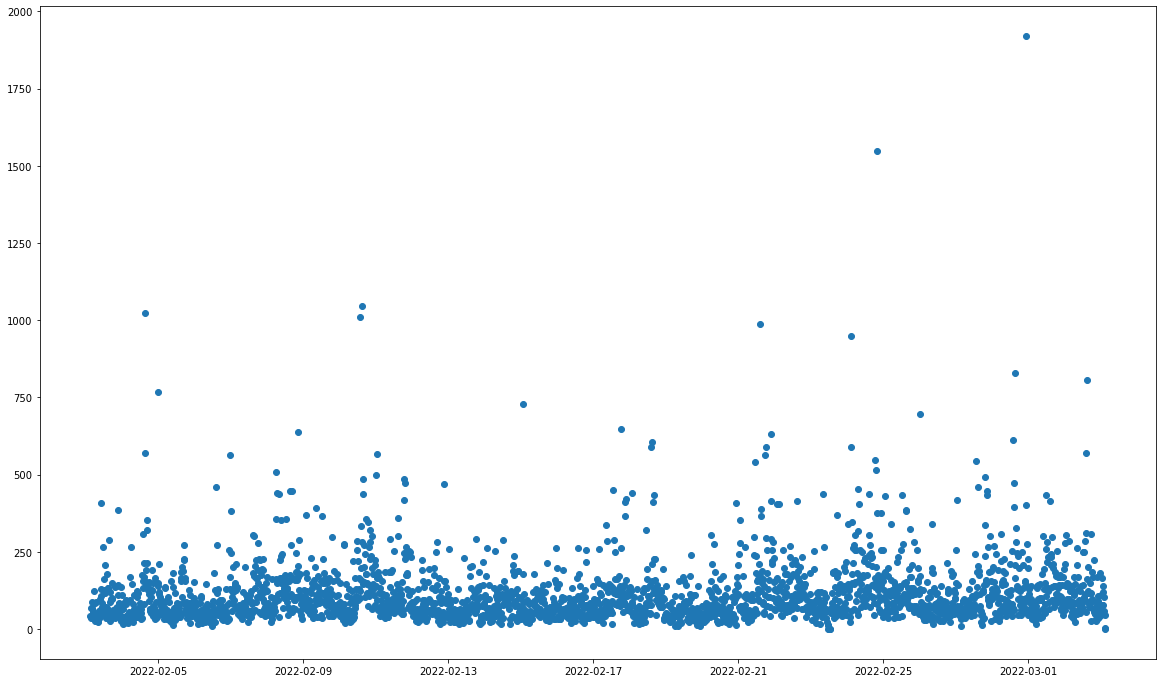

In [72]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

값이 커짐에 따라 변동폭도 증가하므로 명확한 아웃라이어를 보기위해 비트코인의 가격 상승을 반영해준다.

In [73]:
df['Gap'] = df['Gap'] / df['Low']

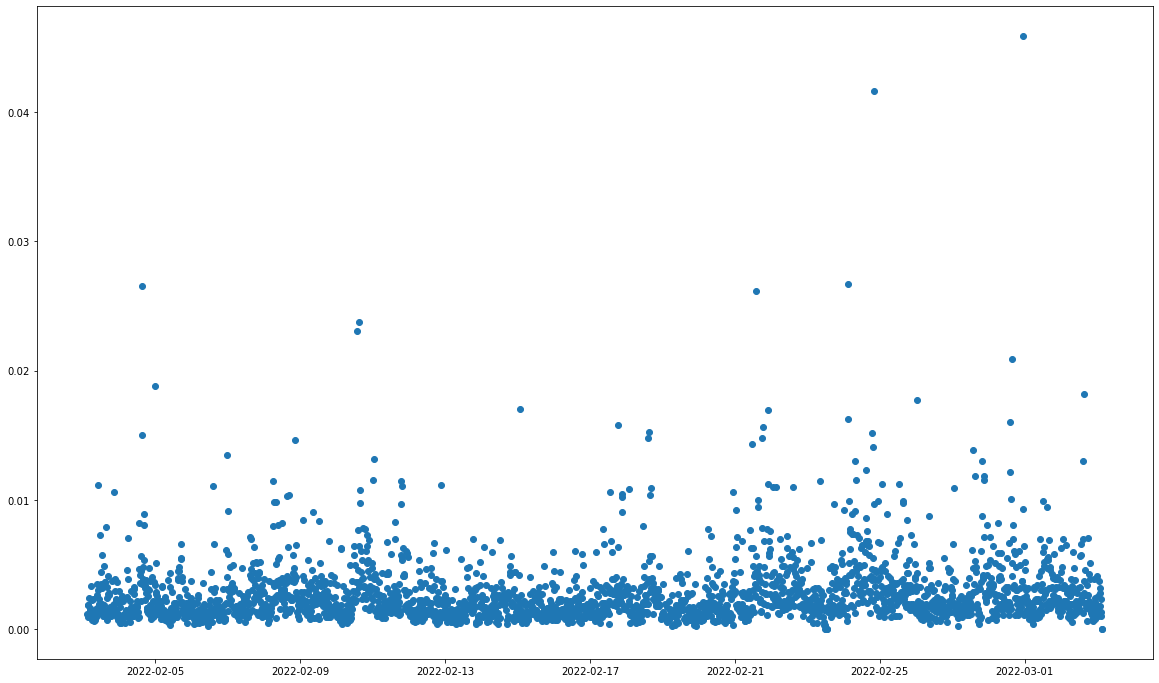

In [74]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

In [75]:
def get_macd(df):
    price = df['Adj Close']
    exp12 = price.ewm(span = 12, adjust=False).mean()
    exp26 = price.ewm(span = 26, adjust=False).mean()
    macd = exp12 - exp26
    exp = macd.ewm(span=9,adjust=False).mean()
    return exp

def get_rsi(df, period):
    close_price = df['Close']
    delta = close_price.diff()
    gains,drops = delta.copy(),delta.copy()
    gains[gains < 0] = 0
    drops[drops > 0] = 0
    au = gains.ewm(com=period-1, min_periods=period).mean()
    ad = drops.abs().ewm(com=period-1, min_periods=period).mean()
    rs = au / ad
    rsi = pd.Series(100 - (100 / (1 + rs)))
    return rsi

def get_vwap(df):
    volumes = df['Volume']
    price = df['Adj Close']
    vwap = ((volumes * price).cumsum()) / volumes.cumsum()
    return vwap

In [76]:
df['VWAP'] = get_vwap(df)
df['RSI'] = get_rsi(df,7)
df['MACD'] = get_macd(df)
df

,Open,High,Low,Close,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,,,,,
2022-02-03 03:00:00,36997.386719,36997.386719,36954.027344,36955.273438,36955.273438,0,0.001173,NaN,NaN,0.000000
2022-02-03 03:15:00,36966.984375,36988.691406,36920.898438,36922.066406,36922.066406,165888,0.001836,36922.066406,NaN,-0.529799
2022-02-03 03:30:00,36918.144531,36935.207031,36899.984375,36931.457031,36931.457031,29073408,0.000955,36931.403754,NaN,-1.212863
2022-02-03 03:45:00,36931.261719,36931.261719,36862.578125,36870.757812,36870.757812,25690112,0.001863,36903.040058,NaN,-2.921839
2022-02-03 04:00:00,36868.261719,36948.675781,36861.207031,36945.785156,36945.785156,35790848,0.002373,36919.903804,NaN,-3.980574
...,...,...,...,...,...,...,...,...,...,...
2022-03-03 02:15:00,43739.042969,43797.878906,43739.042969,43795.156250,43795.156250,10727424,0.001345,42310.860086,41.389384,-13.460880
2022-03-03 02:30:00,43791.382812,43791.382812,43687.863281,43791.257812,43791.257812,145903616,0.002370,42311.217923,41.003954,-17.961382
2022-03-03 02:45:00,43783.078125,43806.292969,43760.609375,43806.292969,43806.292969,12699648,0.001044,42311.249377,43.376514,-21.752542


In [77]:
df = df.dropna()
df = df.drop(['Open','Close','High','Low'], axis=1)
df


,Adj Close,Volume,Gap,VWAP,RSI,MACD
Datetime,,,,,,
2022-02-03 04:45:00,36960.527344,29161472,0.001080,36929.062455,58.044281,-5.291235
2022-02-03 05:00:00,36913.507812,14399488,0.001605,36927.670551,42.164652,-5.562440
2022-02-03 05:15:00,37028.507812,77942784,0.003304,36960.575160,67.519793,-4.204532
2022-02-03 05:30:00,37046.218750,48054272,0.001164,36974.919394,69.891456,-1.604562
2022-02-03 05:45:00,37040.886719,55218176,0.001249,36985.566189,68.143790,1.556203
...,...,...,...,...,...,...
2022-03-03 02:15:00,43795.156250,10727424,0.001345,42310.860086,41.389384,-13.460880
2022-03-03 02:30:00,43791.257812,145903616,0.002370,42311.217923,41.003954,-17.961382
2022-03-03 02:45:00,43806.292969,12699648,0.001044,42311.249377,43.376514,-21.752542


<AxesSubplot:>

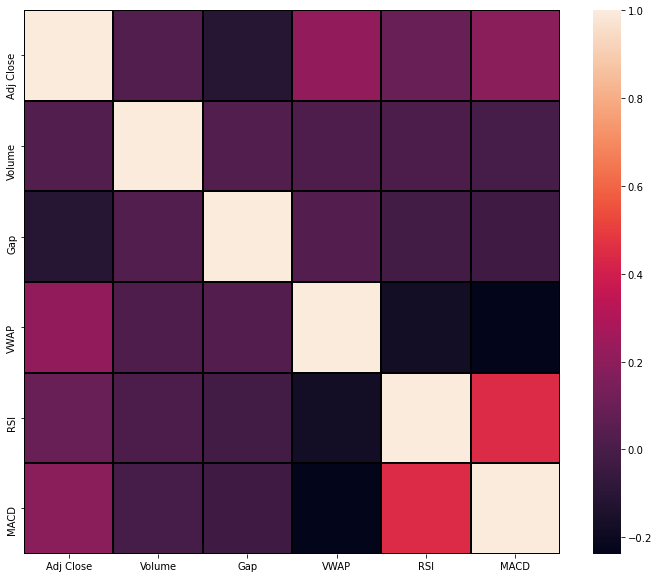

In [78]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidth=1,linecolor='black')

vwap와 rsi가 음의 상관관계를 띄는 것을 확인할 수 있다. 또한 gap은 volume과 양의 상관 관계를 띄는데 이로써 거래량이 튀면 고점이 증가한다는 것을 확인할 수 있다.

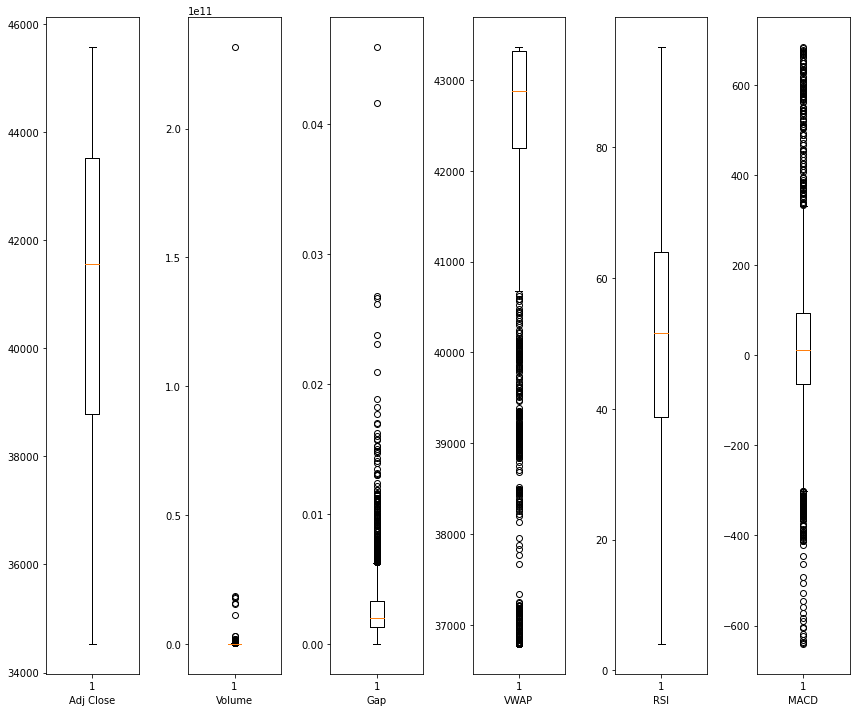

In [79]:
fig,axes = plt.subplots(1,6,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(1,6,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. gap, vwap, macd가 특히 심하다.


In [80]:
q_1 = df.apply(lambda x: np.quantile(x,0.25))
q_3 = df.apply(lambda x: np.quantile(x,0.75))
iqr = q_3 - q_1
min_p = q_1 - 2.5 * iqr
max_p = q_3 + 2.5 * iqr
print(min_p,max_p)

Adj Close    2.693885e+04
Volume      -3.001897e+08
Gap         -3.702699e-03
VWAP         3.958584e+04
RSI         -2.466734e+01
MACD        -4.593217e+02
dtype: float64 Adj Close    5.536078e+04
Volume       4.278743e+08
Gap          8.280028e-03
VWAP         4.598472e+04
RSI          1.274787e+02
MACD         4.889212e+02
dtype: float64


5분 단위 데이터라 그런지 volume이 0으로 잡히는 경우가 많다. 따라서 volume을 제외하고 이상치를 구해준다.

In [81]:
outliers = np.where((df < min_p) | (df > max_p))
outliers

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
          21,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,
          31,   32,   33,   34,   35,   36,   37,   38,   39,   40,   41,
          42,   43,   44,   45,   46,   47,   48,   49,   50,   51,   52,
          53,   54,   55,   56,   57,   58,   59,   60,   61,   62,   63,
          64,   65,   65,   66,   67,   68,   69,   70,   71,   72,   73,
          74,   75,   76,   77,   78,   79,   80,   81,   82,   82,   83,
          84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
          95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
         106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,
         117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
         128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  137,
         137,  138,  138,  138,  139, 

In [82]:
len(outliers[0])

681

In [83]:
from collections import defaultdict
row,col = outliers
outliers_cols = defaultdict(list)
for r,c in zip(row,col):
    outliers_cols[df.columns[c]].append(r)
outliers_cols

defaultdict(list,
            {'VWAP': [0,
              1,
              2,
              3,
              4,
              5,
              6,
              7,
              8,
              9,
              10,
              11,
              12,
              13,
              14,
              15,
              16,
              17,
              18,
              19,
              20,
              21,
              22,
              23,
              24,
              25,
              26,
              27,
              28,
              29,
              30,
              31,
              32,
              33,
              34,
              35,
              36,
              37,
              38,
              39,
              40,
              41,
              42,
              43,
              44,
              45,
              46,
              47,
              48,
              49,
              50,
              51,
              52,
              53,
            

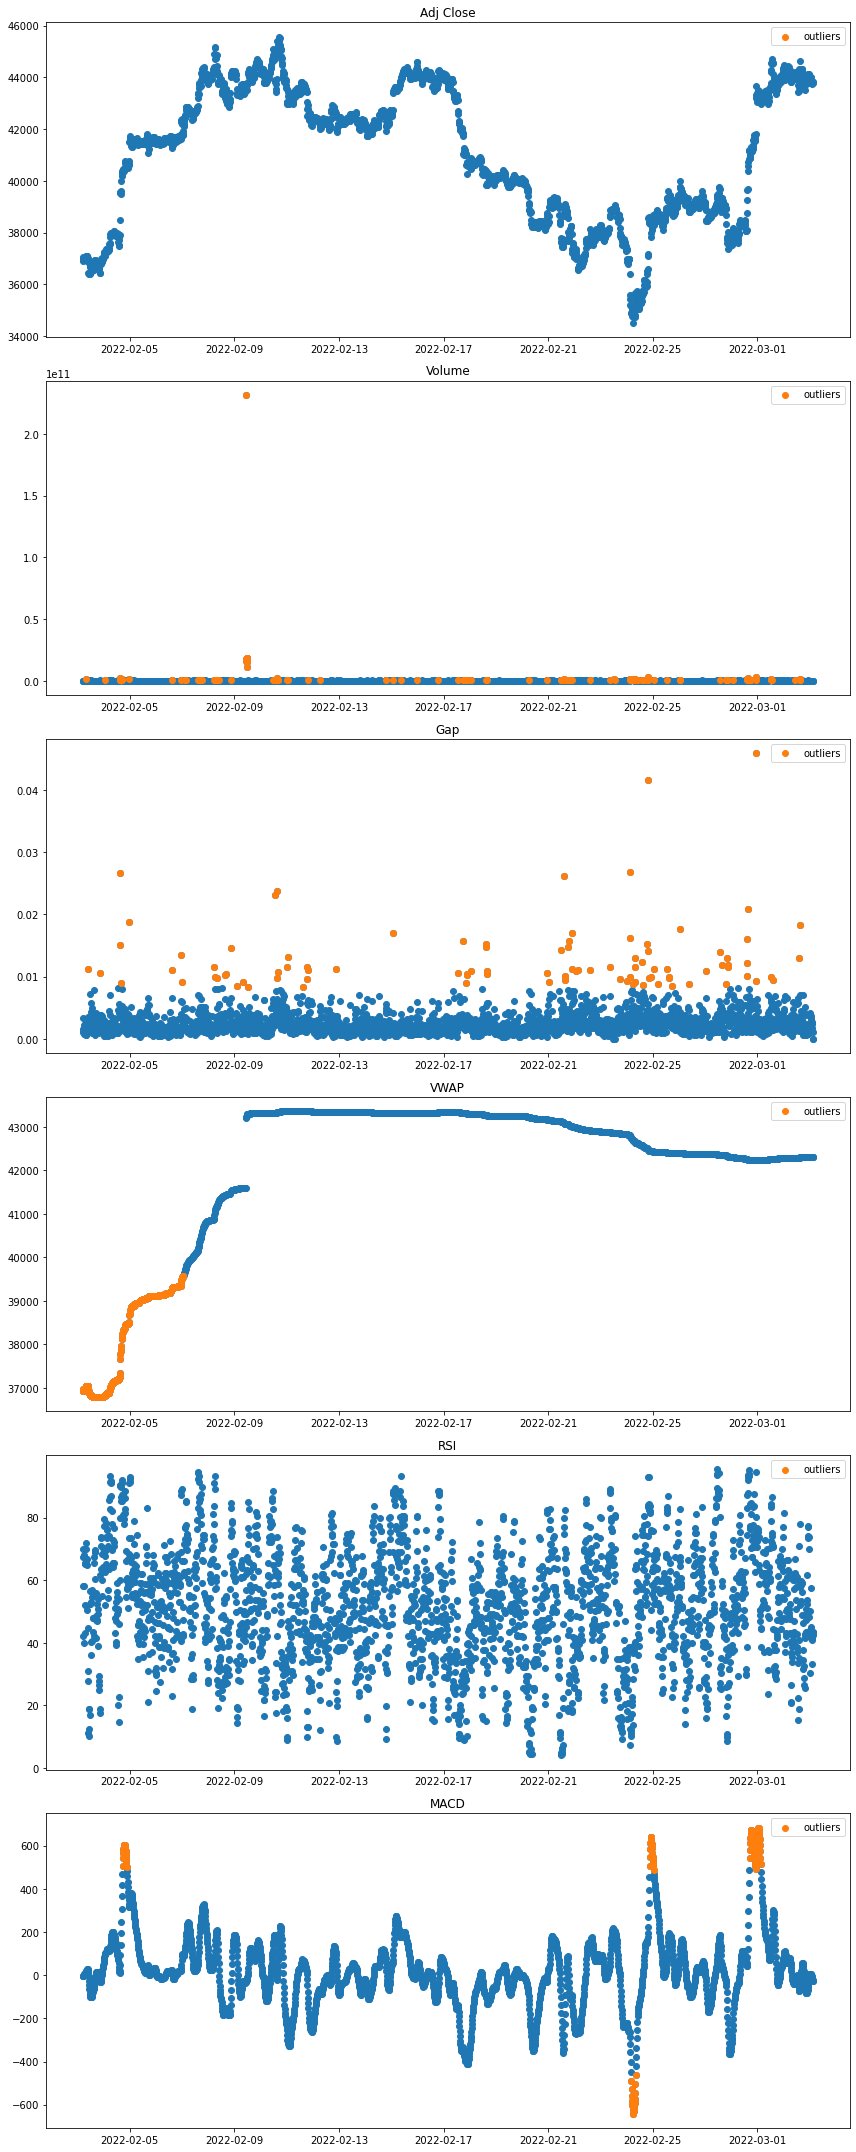

In [84]:
fig,axes = plt.subplots(6,1,figsize=(12,30))
for i, c in enumerate(df.columns,start=1):
    index = df[c].index
    plt.subplot(6,1,i)
    plt.title(c)
    plt.scatter(x=index,y=df[c])
    # if c!='Volume':
    plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
    plt.legend()
plt.tight_layout()

아웃라이어를 제거하는 것보다 포함하는 것이 5분 차트에 있어서는 더욱 예측도가 좋았다.


모델을 생성하고 비교해보자.

In [85]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42))
])
lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])
rf_model = Pipeline([
    ('std_scaler', StandardScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True))
])

In [86]:
def create_train_data(df):
    X = df.drop(['Adj Close','Volume'],axis=1)
    y = df['Adj Close'] #비트코인의 봉 평균가.
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=24)
    return train_X, test_X, train_y, test_y

In [87]:
train_X, test_X, train_y, test_y = create_train_data(df)

In [88]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 5537409.554272411, alpha: 1000
mse: 5497591.206092764, alpha: 300
mse: 5485567.65943936, alpha: 100
mse: 5471433.600595223, alpha: 30
mse: 5425798.107401479, alpha: 10
mse: 5189689.715988774, alpha: 1
mse: 6782964.281134, alpha: 1000
mse: 6274047.333699798, alpha: 300
mse: 5612770.703405558, alpha: 100
mse: 5466180.275159497, alpha: 30
mse: 5448954.302423464, alpha: 10
mse: 5231720.305083847, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1596160872.9665089, tolerance: 1218127.2977910996
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1596160872.9665089, tolerance: 1218127.2977910996
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('std_scaler', StandardScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [89]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

In [90]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

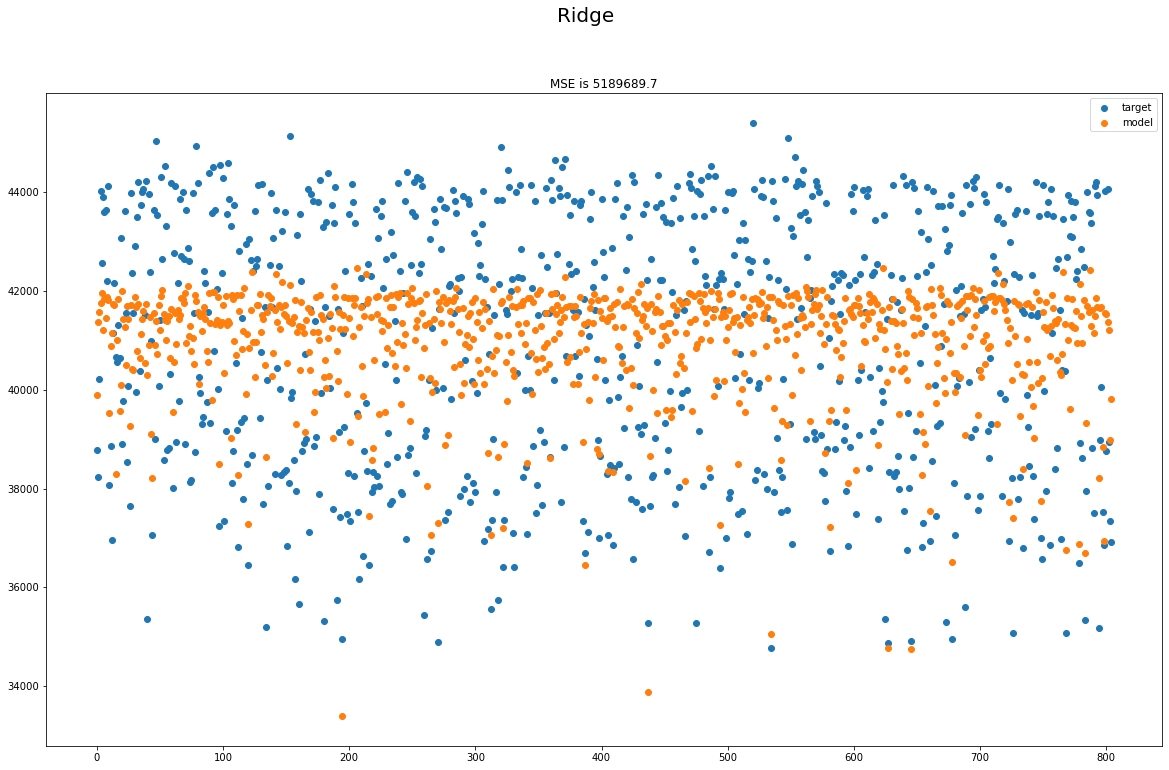

In [91]:
visualize(r_pred,test_y,"Ridge")

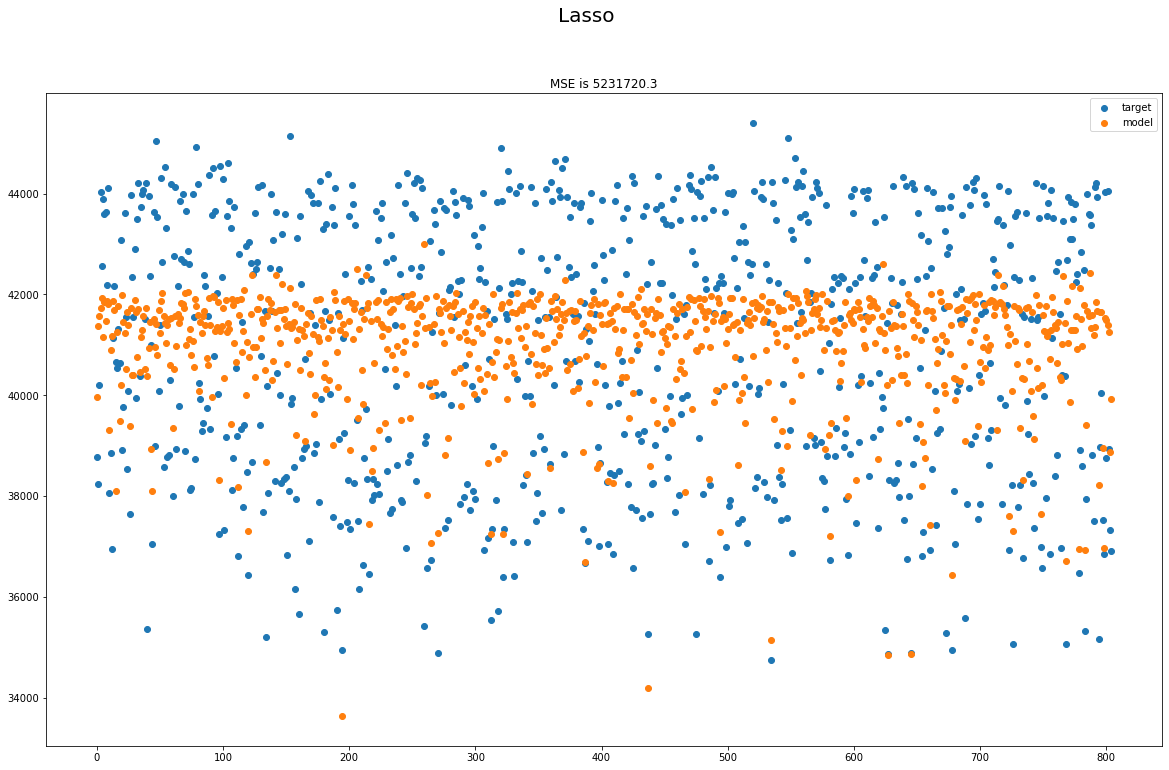

In [92]:
visualize(l_pred, test_y, "Lasso")

In [93]:
def visualize_plot(pred,target,name):
    pred = pd.Series(pred, index=target.index)
    plt.figure(figsize=(12,10))
    pred.sort_index().plot(label='model')
    test_y.sort_index().plot(label='target')
    plt.title(name)
    plt.legend()


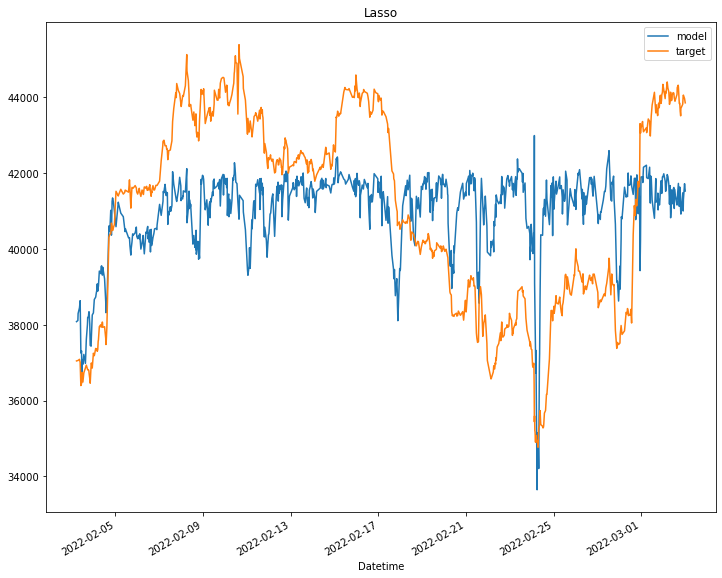

In [94]:
visualize_plot(l_pred, test_y, 'Lasso')

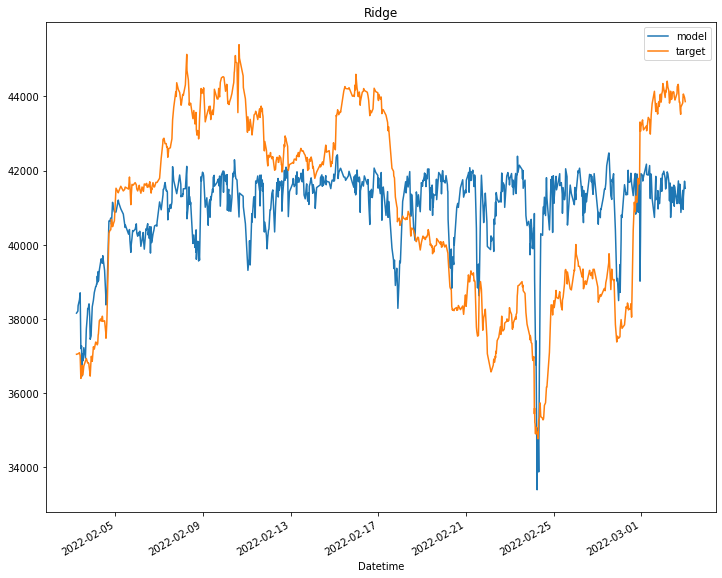

In [95]:
visualize_plot(r_pred, test_y, "Ridge")

In [96]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

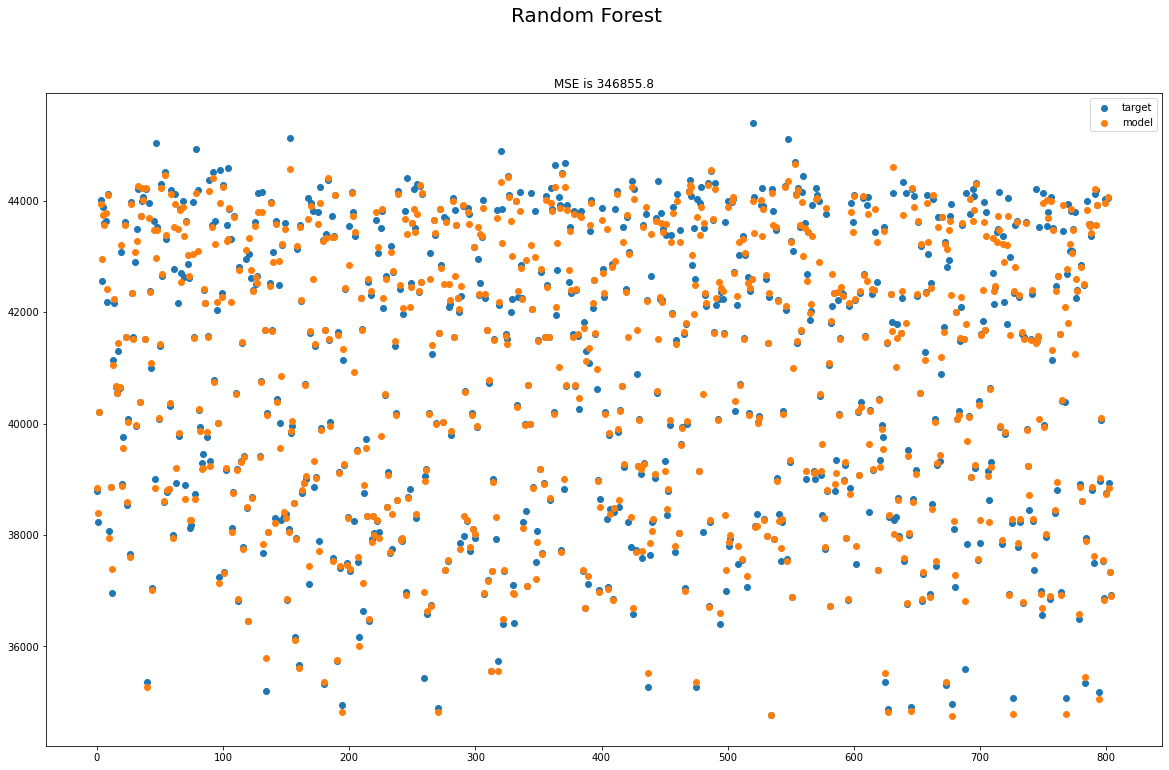

In [97]:
visualize(rf_pred, test_y, "Random Forest")

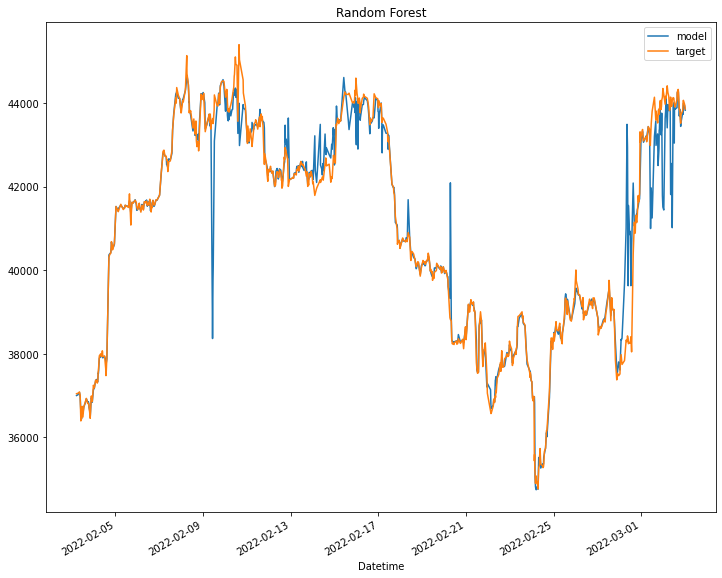

In [98]:
visualize_plot(rf_pred, test_y, "Random Forest")

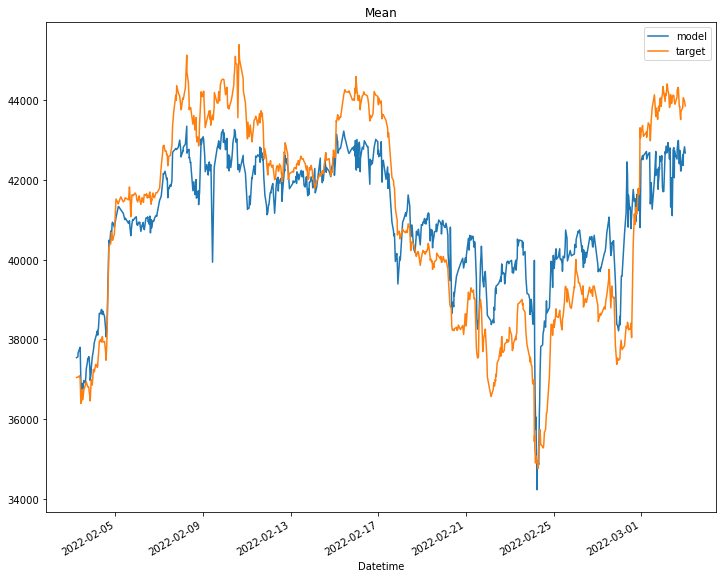

In [99]:
visualize_plot((l_pred + rf_pred)/2,test_y,"Mean")

In [100]:
from joblib import dump #모델을 저장한다.
dump(rf_model,'model/BTCUSD_RF_15m.joblib')


['model/BTCUSD_RF_15m.joblib']